# Social Networks Final Project: Protein-Protein Interactions (PPI)

**Group members:**

Marina Iuliana Aur, *1809715* <br>
Cristiana Di Tullio, *1803880*

## Import libraries and dependencies

In [89]:
# Run if needed
%pip install torch-geometric
%pip install markov-clustering

In [90]:
# Import libraries
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import pprint
import torch
from torch.cuda import is_available
from torch_geometric.utils import to_networkx, negative_sampling
import markov_clustering as mc
from scipy.sparse import csr_matrix

In [4]:
# CPU/GPU
device = 'cpu'
if torch.cuda.is_available():
	device = 'gpu'

print(f'Using device {device}')

Using device cpu


## Utility functions

In [5]:
# Graph visualization functions from the SNOM Lab
# NOTE: the original input object was not a normal networkx graph
def convert_to_networkx(graph):
	g = to_networkx(graph, node_attrs = ['x'])
	y = graph.y.numpy()
	return g, y

def plot_graph(g, y):
	plt.figure(figsize = (9, 7))
	nx.draw_spring(g, node_size = 30, arrows = False, node_color = y)
	plt.show()

In [49]:
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")

## 1) Introduction


 ### 1.1) Dataset description

 [**BIOGRID CORONAVIRUS dataset**](
https://downloads.thebiogrid.org/File/BioGRID/Release-Archive/BIOGRID-4.4.236/BIOGRID-CORONAVIRUS-4.4.236.tab3.zip)

 (every row represents the interaction between two proteins)

In [101]:
# Load PPI network
covid_df = pd.read_csv('/content/BIOGRID-CORONAVIRUS-4.4.236.tab3.txt', sep = '\t')
covid_df.head()

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,141211,850980,852501,31542,32899,YLR274W,YBR202W,MCM5,MCM7,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_009761,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
1,141212,852501,850980,32899,31542,YBR202W,YLR274W,MCM7,MCM5,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
2,141213,850980,856680,31542,36697,YLR274W,YEL032W,MCM5,MCM3,BOB1|CDC46|MCM DNA helicase complex subunit MC...,...,-,NP_010882,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
3,141214,856680,850980,36697,31542,YEL032W,YLR274W,MCM3,MCM5,MCM DNA helicase complex subunit MCM3|L000001039,...,-,NP_013376,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)
4,141215,852501,850793,32899,31376,YBR202W,YLR103C,MCM7,CDC45,CDC47|MCM DNA helicase complex subunit MCM7|L0...,...,-,NP_013204,-,-,-,-,-,-,Saccharomyces cerevisiae (S288c),Saccharomyces cerevisiae (S288c)


In [102]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60777 entries, 0 to 60776
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   #BioGRID Interaction ID             60777 non-null  int64 
 1   Entrez Gene Interactor A            60777 non-null  object
 2   Entrez Gene Interactor B            60777 non-null  object
 3   BioGRID ID Interactor A             60777 non-null  int64 
 4   BioGRID ID Interactor B             60777 non-null  int64 
 5   Systematic Name Interactor A        60777 non-null  object
 6   Systematic Name Interactor B        60777 non-null  object
 7   Official Symbol Interactor A        60777 non-null  object
 8   Official Symbol Interactor B        60777 non-null  object
 9   Synonyms Interactor A               60777 non-null  object
 10  Synonyms Interactor B               60777 non-null  object
 11  Experimental System                 60777 non-null  ob

In [103]:
ppi = covid_df[['Official Symbol Interactor A', 'Official Symbol Interactor B']]
ppi.head()

,Official Symbol Interactor A,Official Symbol Interactor B
0,MCM5,MCM7
1,MCM7,MCM5
2,MCM5,MCM3
3,MCM3,MCM5
4,MCM7,CDC45


### 1.2) Network analysis

(including degree, betweenness, closeness, and other relevant metrics)

In [104]:
# Check the shape of the dataframe without duplicates (it will not remove rows with the same genes but in different columns)
ppi.drop_duplicates().shape

(44265, 2)

In [105]:
ppi_network = nx.from_pandas_edgelist(ppi,
                                      source = "Official Symbol Interactor A",
                                      target = "Official Symbol Interactor B",
                                      create_using = nx.Graph())      # nx.Graph() doesn't allow duplicated edges

print(ppi_network) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 8144 nodes and 43731 edges


In [119]:
# Identify self-loops
self_loops_bio = list(nx.selfloop_edges(ppi_network))
print("Number of self loops: ", len(self_loops_bio))
print("Self-loops over Total edges:", round(nx.number_of_selfloops(ppi_network) / len(ppi_network.edges), 4), "\n")

# Remove self-loops
ppi_network.remove_edges_from(self_loops_bio)
print("Graph without self-loops:", ppi_network)

Number of self loops:  0
Self-loops over Total edges: 0.0 

Graph without self-loops: Graph with 8144 nodes and 43625 edges


In [107]:
# Isolate the largest connected component (LCC) -> ha senso?
components = list(nx.connected_components(ppi_network))
largest_component = max(components, key = len)
LCC_ppi = ppi_network.subgraph(largest_component)
print(LCC_ppi)

Graph with 8120 nodes and 43610 edges


In [108]:
# Compute metrics
degree = LCC_ppi.degree()
bet = nx.betweenness_centrality(LCC_ppi, k = 100, normalized = True) # richiede troppo tempo, per ora normalizzo con k=100
# clos = nx.closeness_centrality(LCC_ppi) -> richiede troppo tempo

In [109]:
try:
    eigen = nx.eigenvector_centrality(LCC_ppi, max_iter = 500, tol = 1e-04)
except nx.PowerIterationFailedConvergence as e:
    print(f"Failed to converge: {e}")

In [110]:
degree_dict = dict(degree)
ratio = {}

for node in LCC_ppi.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [111]:
# Insert metrics in the dictionary
nodes = LCC_ppi.nodes()
gene_measures = dict(nodes)

for gene in gene_measures:
    gene_measures[gene]["Degree"] = degree[gene]
    gene_measures[gene]["Betweeness"] = bet[gene]
    #gene_measures[gene]["Closeness"] = clos[gene]
    gene_measures[gene]["Eigen"] = eigen[gene]
    gene_measures[gene]["BetoverDeg"] = ratio[gene]
print_dict("Gene measures:", gene_measures)

Gene measures:
--------------
{'CCND1': {'BetoverDeg': 2.5383761597094784e-05,
           'Betweeness': 0.00012691880798547392,
           'Degree': 5,
           'Eigen': 0.0016793527524739153},
 'CDC45': {'BetoverDeg': 0.0,
           'Betweeness': 0.0,
           'Degree': 1,
           'Eigen': 0.00011744296950014412},
 'MCM3': {'BetoverDeg': 1.4216865626295276e-06,
          'Betweeness': 1.8481925314183858e-05,
          'Degree': 13,
          'Eigen': 0.015888104979471223},
 'MCM5': {'BetoverDeg': 6.077296779797542e-06,
          'Betweeness': 0.00013977782593534347,
          'Degree': 23,
          'Eigen': 0.02488949804251085},
 'MCM7': {'BetoverDeg': 1.2995910846764336e-05,
          'Betweeness': 0.0002599182169352867,
          'Degree': 20,
          'Eigen': 0.013110448865177067}}



In [112]:
# Build a metrics dataframe
measures_ppi = pd.DataFrame.from_dict(gene_measures, orient ='index')
measures_ppi = measures_ppi.reset_index()
measures_ppi.rename(columns={'index': 'Gene'}, inplace = True)

# Sort the output
sorted_metrics = measures_ppi.sort_values(by = 'Degree', ascending = False)
sorted_metrics.reset_index(drop = True, inplace = True)
sorted_metrics['Ranking'] = sorted_metrics.index + 1
sorted_metrics.set_index('Ranking', inplace = True)

# Visualize the output
sorted_metrics.head()

,Gene,Degree,Betweeness,Eigen,BetoverDeg
Ranking,,,,,
1,M,2090,0.116915,0.242158,0.000056
2,ORF7b,1776,0.092268,0.215598,0.000052
3,nsp6,1699,0.049482,0.211617,0.000029
4,N,1538,0.116457,0.122532,0.000076
5,nsp4,1498,0.055729,0.205163,0.000037


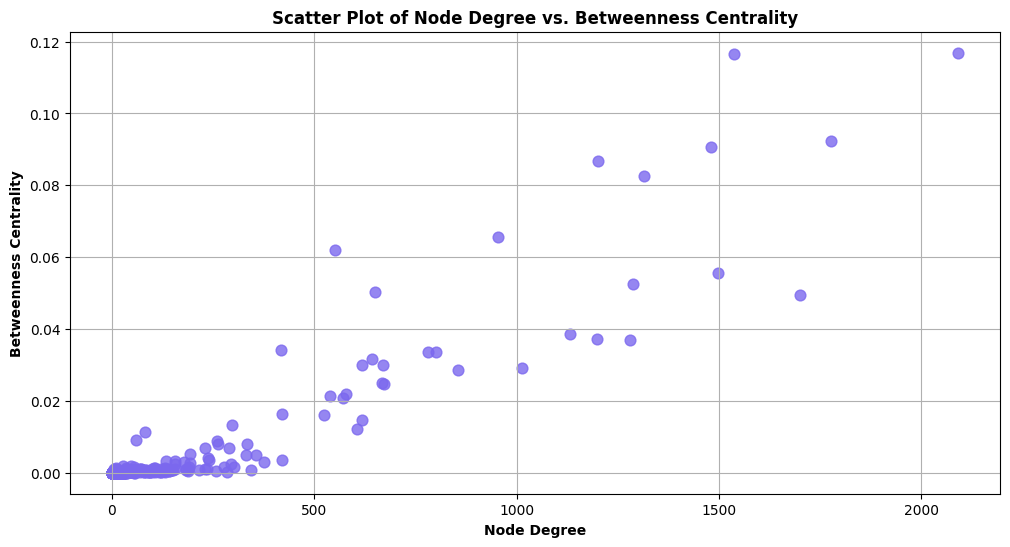

In [113]:
# Scatterplot of degree vs betweeness
x = measures_ppi['Degree']
y = measures_ppi['Betweeness']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, color = 'mediumslateblue', alpha = 0.8, s = 60)

plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight='bold')
plt.xlabel('Node Degree', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.grid()
plt.show()

### 1.3) Network visualization

In [ ]:
# Plot the PPI Largest Connected Component -> troppo grande?
pos = nx.spring_layout(LCC_ppi, seed=42)

plt.figure(figsize = (14, 10))
nx.draw(LCC_ppi, pos, with_labels = True, node_color = 'violet', node_size = 1000,
        edge_color = 'gray', linewidths = 1, font_size = 16)

plt.title("PPI Largest connected Component Network", fontweight = 'bold')
plt.show()

In [ ]:
# CAREFUL
# Takes a while to plot
plt.figure(figsize = (9, 7))
nx.draw_spring(LCC_ppi, node_size = 30, arrows = False, node_color = 'mediumslateblue')
plt.title('Protein-Protein Interaction Network')
plt.show()

For a better visualization, try a 3D plot with `plotly`.

In [ ]:
!pip install igraph

In [ ]:
# Try a better visualization
import igraph as ig

# Assuming G is your NetworkX graph
edges = list(G.edges())
# Assuming G is your NetworkX graph
nodes = list(G.nodes())

# Create a mapping from node names to integers
node_mapping = {node: idx for idx, node in enumerate(nodes)}

# Convert the edges using the mapping
edges = [(node_mapping[u], node_mapping[v]) for u, v in G.edges()]

# Create an iGraph object using the mapped edges
ig_graph = ig.Graph(edges=edges, directed=False)

# Optionally, add the node attributes (e.g., original names) back to the igraph object
#ig_graph.vs["name"] = nodes

import plotly.graph_objs as go

# Get the 3D layout from iGraph
layout = ig_graph.layout('kk', dim=3)  # 'kk' stands for Kamada-Kawai layout

# Extract the x, y, z coordinates of each node
x_nodes = [coord[0] for coord in layout]
y_nodes = [coord[1] for coord in layout]
z_nodes = [coord[2] for coord in layout]

# Create a scatter plot for the nodes
node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers',
    marker=dict(size=4, color='blue'),
    text=[str(i) for i in range(len(x_nodes))],  # Node labels
    hoverinfo='text'
)

# Create lines between connected nodes
edge_trace = []
for edge in ig_graph.get_edgelist():
    x0, y0, z0 = layout[edge[0]]
    x1, y1, z1 = layout[edge[1]]
    edge_trace.append(go.Scatter3d(
        x=[x0, x1, None],
        y=[y0, y1, None],
        z=[z0, z1, None],
        mode='lines',
        line=dict(color='black', width=0.5)
    ))

# Combine the node and edge traces
data = edge_trace + [node_trace]

# Define the layout for the 3D plot
layout = go.Layout(
    showlegend=False,
    scene=dict(
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        zaxis=dict(showgrid=False, zeroline=False)
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Plot the figure
fig = go.Figure(data=data, layout=layout)
fig.show()

## 2) Community detection

Experimenting with clustering algorithms to investigate if proteins within the same cluster are more likely to interact with each other than with proteins in other clusters.

- KWIKCLUSTER/PIVOT algorithm
- Markov Cluster algorithm
- Louvain algorithm

### 2.1) KWIKCLUSTER (or PIVOT) Algorithm

### 2.2) Markov Cluster Algorithm

In [ ]:
# Run MCL with inflation parameter = 1.8 -> problemi da risolvere
matrix = nx.to_scipy_sparse_array(LCC_ppi)
result = mc.run_mcl(matrix, inflation = 1.8)
clusters = mc.get_clusters(result)

### 2.3) Louvain Algorithm

In [59]:
# Run the Louvain algorithm with gamma = 1
louvain_communities = nx.community.louvain_communities(LCC_ppi, weight = 'weight', resolution = 1.0, seed = 42)

In [115]:
print("Number of Louvain Communities: ", len(louvain_communities))

Number of Louvain Communities:  8


In [83]:
print("First Community 15 Genes: \n")
genes_list = list(louvain_communities[0])
for gene in genes_list[:15]:
    print(gene)

First Community 15 Genes: 

HRG
DHRS3
KRT25
CRY2
PCNXL4
TANGO6
ITGB6
FMN2
CD44
MSMP
DSC1
TLN1
ULK4
GPR112
OTOP2


In [84]:
louvain_community_map = {}
for idx, community in enumerate(louvain_communities):
    for node in community:
        louvain_community_map[node] = idx

In [85]:
colors = [louvain_community_map[node] for node in LCC_ppi.nodes()]

In [ ]:
pos = nx.spring_layout(LCC_ppi)
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(LCC_ppi, pos, node_color = colors, cmap = plt.get_cmap('Set1'), node_size = 50)
nx.draw_networkx_edges(LCC_ppi, pos, alpha=0.5)
plt.title('Louvian Communities Network')
plt.show()

## 3) Link Prediction with Graph Neural Networks (GNNs)

 ### 3.1) Exploring different models to perform the prediction task

 GAT, GCN, etc.

 Transformers?

### 3.2) Evaluation of results

(using metrics such as confusion matrix, accuracy, precision, recall, F1 score, hits@k, etc.)

## [Optional: Influence and Homophily?]

## 4) Conclusions